#*```IMPORT```*

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input


#*```MOUNT DRIVE```*

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#*```PATH```*

In [ ]:
# Paths and parameters
DATA_DIR = "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 15
EPOCHS_FINE = 25
CLASS_NAMES = ["Immature", "Mature", "Normal"]

SAVE_DIR_H5 = "/content/drive/My Drive/PROJECT1/trained models/H5"
SAVE_DIR_KERAS = "/content/drive/My Drive/PROJECT1/trained models/keras"
os.makedirs(SAVE_DIR_H5, exist_ok=True)
os.makedirs(SAVE_DIR_KERAS, exist_ok=True)

# Data generators with augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

valid_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "valid"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
print("Class indices:", train_data.class_indices)

Found 3712 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Class indices: {'Immature': 0, 'Mature': 1, 'Normal': 2}



# Compute class weights to handle class imbalance

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Create EfficientNet-B3 model with custom head

In [ ]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


# Compile model for initial training

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

print("Training EfficientNet-B3 classification head...")
history_head = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=[es, rlr]
)

Training EfficientNet-B3 classification head...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 1829s 15s/step - accuracy: 0.4718 - loss: 1.0295 - val_accuracy: 0.7615 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.7532 - loss: 0.6235 - val_accuracy: 0.8003 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 416ms/step - accuracy: 0.8211 - loss: 0.5016 - val_accuracy: 0.8610 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.8289 - loss: 0.4561 - val_accuracy: 0.8480 - val_loss: 0.3994 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 46s 400ms/step - accuracy: 0.8359 - loss: 0.4268 - val_accuracy: 0.8601 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 405ms/step - accuracy: 0.8451 - loss: 0.4095 - val_accuracy: 0.8892 - val_loss: 0.3255 - learning_rate: 0.0010
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.8


# Unfreeze last 50 layers (except BatchNorm) for fine-tuning

In [ ]:
for layer in base_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

print("Fine-tuning EfficientNet-B3 last layers...")
history_fine = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=[es, rlr]
)

Fine-tuning EfficientNet-B3 last layers...
Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 99s 538ms/step - accuracy: 0.8909 - loss: 0.2706 - val_accuracy: 0.9475 - val_loss: 0.1612 - learning_rate: 1.0000e-05
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.9184 - loss: 0.2188 - val_accuracy: 0.9604 - val_loss: 0.1269 - learning_rate: 1.0000e-05
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 403ms/step - accuracy: 0.9333 - loss: 0.1738 - val_accuracy: 0.9701 - val_loss: 0.1033 - learning_rate: 1.0000e-05
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 408ms/step - accuracy: 0.9460 - loss: 0.1543 - val_accuracy: 0.9563 - val_loss: 0.1209 - learning_rate: 1.0000e-05
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 400ms/step - accuracy: 0.9565 - loss: 0.1285 - val_accuracy: 0.9782 - val_loss: 0.0702 - learning_rate: 1.0000e-05
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.9597 - loss: 0.1209 - val_accuracy: 0.9677 - val_loss: 0.0893 - learning_rate: 1.0000e-05
Epo


# Plot training and validation accuracy/loss graphs

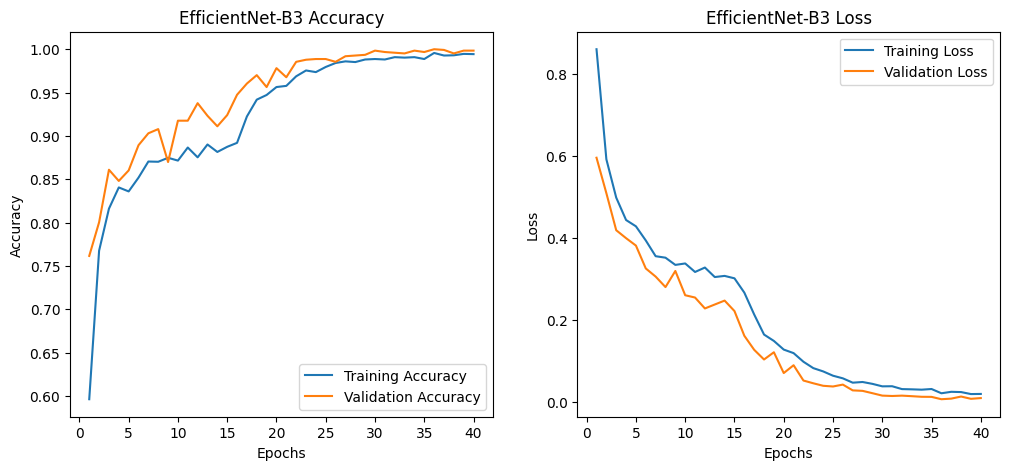

In [ ]:
def plot_training(history_head, history_fine, model_name="EfficientNet-B3"):
    acc = history_head.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history_head.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history_head.history['loss'] + history_fine.history['loss']
    val_loss = history_head.history['val_loss'] + history_fine.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history_head, history_fine, model_name="EfficientNet-B3")

In [ ]:
print("Evaluating EfficientNet-B3 on test set...")
loss, acc = model.evaluate(test_data)
print(f"Test accuracy: {acc*100:.2f}%")

accuracy_str = f"{acc*100:.2f}".replace(".", "_")
model_name_h5 = f"efficientnetb3({accuracy_str}).h5"
model_name_keras = f"efficientnetb3({accuracy_str}).keras"

model.save(os.path.join(SAVE_DIR_H5, model_name_h5))
model.save(os.path.join(SAVE_DIR_KERAS, model_name_keras))

print(f"Models saved as:\n- {os.path.join(SAVE_DIR_H5, model_name_h5)}\n- {os.path.join(SAVE_DIR_KERAS, model_name_keras)}")

Evaluating EfficientNet-B3 on test set...
39/39 ━━━━━━━━━━━━━━━━━━━━ 758s 20s/step - accuracy: 0.9972 - loss: 0.0110


Test accuracy: 99.84%
Models saved as:
- /content/drive/My Drive/PROJECT1/trained models/H5/efficientnetb3(99_84).h5
- /content/drive/My Drive/PROJECT1/trained models/keras/efficientnetb3(99_84).keras
